In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# from numba import jit

from matplotlib import rcParams 
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' 
rcParams['text.usetex']         = True 
rcParams['font.family']         = 'sans-serif' 
rcParams['font.sans-serif']     = ['Helvetica']
rcParams['animation.html']      = 'html5'

%matplotlib inline

### Problem 3.13

In [ ]:
def V(x,y,N=100):
    ## unitless: V = V(x,y)/V_0 | x,y = x,y/a 
    V = 0
    for n in range(N):
        V += np.exp(-(2*n+1)*np.pi*x)*np.sin((2*n+1)*np.pi*y)/(2*n+1)
        # V += np.exp(-(4*n+2)*np.pi*x)*np.sin((4*n+2)*np.pi*y)/(2*n+1)
    V *= 4/np.pi
    return V

In [ ]:
num = 100
x = np.linspace(0.0,0.1,num) # x: 0,infinity
y = np.linspace(0.0,1.0,num) # y: 0,a
X,Y = np.meshgrid(x,y)

In [ ]:
def plot3d(X,Y,N):
    fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))

    Z = V(X,Y,N)
    ax.plot_surface(X,Y,Z,cmap=plt.cm.coolwarm)

    ax.set_title(r'$N=%d$'%N,size=20)
    ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
    ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
    ax.set_zlabel(r'$V/V_0$',size=20,labelpad=10,rotation=45)
    ax.zaxis.set_rotate_label(False)
    
    ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
    ax.view_init(30, 30)
    
    # plt.savefig('./plots/prob3-13_%d.png'%N,bbox_inches='tight')
    plt.show()

In [ ]:
fps = 10
frn = 100
zarray = np.zeros([num,num,frn])

for i in range(1,frn+1):
    zarray[:,:,i-1] = V(X,Y,N=i)

In [ ]:
def update_plot(frame_number,zarray,plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X,Y,zarray[:,:,frame_number],cmap=plt.cm.coolwarm)
    plot[1] = ax.set_title(r'$N=%d$'%frame_number,size=20)
    
fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))
ax.set_xlim(min(x),max(x))
ax.set_ylim(min(y),max(y))
ax.set_zlim(-1.3,1.3)
ax.zaxis.set_rotate_label(False)
ax.view_init(30,30)

ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
ax.set_zlabel(r'$V/V_0$',size=20,labelpad=10)

ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plot = [ax.plot_surface(X,Y,zarray[:,:,0],cmap=plt.cm.coolwarm,rstride=1,cstride=1),
        ax.set_title(r'$N=%d$'%1,size=20)]
ani = animation.FuncAnimation(fig,update_plot,frn,fargs=(zarray,plot),interval=1000/fps)

In [ ]:
name = './plots/animation'
ani.save(name+'.gif',writer='imagemagick',fps=fps)

In [ ]:
%%bash
convert ./plots/animation.gif -fuzz 5%% -layers Optimize ./plots/animation.gif

### Problem 3.16

In [ ]:
def V(x,y,z=0.5,N=50,M=50):
    V = 0
    for n in range(N+1):
        v = 0
        for m in range(M+1):
            v += np.sin((2*m+1)*np.pi*y)*np.sinh(np.pi*np.sqrt((2*n+1)**2+(2*m+1)**2)*z)/np.sinh(np.pi*np.sqrt((2*n+1)**2+(2*m+1)**2))/(2*m+1)
        v *= np.sin((2*n+1)*np.pi*x)/(2*n+1)
        V += v
    V *= 16/np.pi**2
    return V

In [ ]:
num = 100
x = np.linspace(0.0,1.0,num) # x: 0,infinity
y = np.linspace(0.0,1.0,num) # y: 0,a
X,Y = np.meshgrid(x,y)

In [ ]:
def plot3d(X,Y,z):
    fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))

    ax.plot_surface(X,Y,V(X,Y,z),cmap=plt.cm.coolwarm)

    ax.set_title(r'$z=%.1f$'%z,size=20)
    ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
    ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
    ax.set_zlabel(r'$V/V_0$',size=20,labelpad=20,rotation=45)
    ax.zaxis.set_rotate_label(False)
    
    ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
    ax.view_init(30, -60)
    
    plt.savefig('./plots/prob3-16_%s.png'%str(round(z,2)).replace('.','-'),bbox_inches='tight')
    plt.show()

In [ ]:
z = np.linspace(0.0,1.0,6)
print(z)
for _ in z:
    plot3d(X,Y,_)

In [ ]:
def summ(x):
    res = 0
    for n in range(10):
        res += np.sin((2*n+1)*x)/(2*n+1)
    return res*4/np.pi
print(summ(np.linspace(0.0,1.0,10))**2)

### Finite Difference and Relaxation

In [2]:
# @jit(nopython=True)
def update(V):
    V_new = np.copy(V)
    shape = np.shape(V)
    h = X[0,1]-X[0,0]
    for i in range(1,shape[0]-1):
        for j in range(1,shape[1]-1):
            if (Y[i,j] >= 0.25 and Y[i,j] <= 0.75) and ((X[i,j] >= 0.2 and X[i,j] <= 0.3) or (X[i,j] >= 0.7 and X[i,j] <= 0.8)):
                continue
            V_new[i,j] = (V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1])/4.0
            # print(rho(X[i,j],Y[i,j]))
    return V_new

In [3]:
def plot3d(X,Y,V,N=-1):
    fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))

    ax.plot_surface(X,Y,V,cmap=plt.cm.coolwarm)

    ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
    ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
    ax.set_zlabel(r'$V/V_0$',size=20,labelpad=15,rotation=45)
    ax.zaxis.set_rotate_label(False)
    if N >= 0:
        ax.set_title(r'$N=%d$'%N,size=20)
    ax.set_title('Parallel plate capacitor',size=30)
    
    ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
    ax.view_init(30,30)
    
    # plt.savefig('./plots/prob3-13_%d.png'%N,bbox_inches='tight')
    plt.show()

21


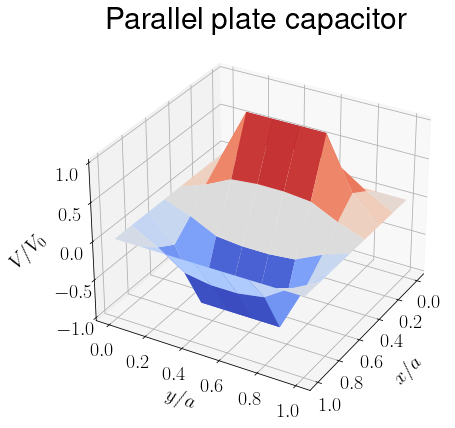

In [4]:
N = 8 # defines grid spacing
x = np.linspace(0.0,1.0,N)
y = np.linspace(0.0,1.0,N)

X,Y = np.meshgrid(x,y)
V = np.zeros(np.shape(X))

def initial(x,y):
    if (y >= 0.25 and y <= 0.75):
        if (x >= 0.2 and x <= 0.3):
            return 1.0
        elif x >= 0.7 and x <= 0.8:
            return -1.0
        else:
            return 0.0
    else:
        return 0.0
    
def set_initial(shape):
    V = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            V[i,j] = initial(X[i,j],Y[i,j])
    return V

V = set_initial(np.shape(X))
# plot3d(X,Y,V)
# print(X)
# print(Y)
# print(V)

i = 0
while True:
    i += 1
    V_new = update(V)
    if np.all(abs(V_new - V) < 1e-5):
        print(i)
        break
    V = V_new
plot3d(X,Y,V)

In [5]:
# @jit(nopython=True)
def gradient(array):
    shape = np.shape(array)
    E_x = np.zeros(shape)
    E_y = np.zeros(shape)
    grid_spacing = abs(X[0,1]-X[0,0])
    for i in range(shape[0]):
        for j in range(shape[1]):
            if j == 0: 
                E_x[i,j] = -(array[i,j+1]-array[i,j])/grid_spacing
            elif j == shape[1]-1:
                E_x[i,j] = -(array[i,j]-array[i,j-1])/grid_spacing
            else:
                E_x[i,j] = -(array[i,j+1] - array[i,j-1])/2.0/grid_spacing
    for i in range(shape[0]):
        for j in range(shape[1]):
            if i == 0: 
                E_x[i,j] = -(array[i+1,j]-array[i,j])/grid_spacing
            elif i == shape[1]-1:
                E_x[i,j] = -(array[i,j]-array[i-1,j])/grid_spacing
            else:
                E_y[i,j] = -(array[i+1,j] - array[i-1,j])/2.0/grid_spacing
    return E_x,E_y

In [6]:
Ex_vac,Ey_vac = gradient(V)

In [7]:
# plt.quiver(X,Y,Ex_vac,Ey_vac)

In [31]:
def eps_rel(x,y):
    if (y >= 0.25 and y <= 0.75) and ((x >= 0.2 and x <= 0.3) or (x >= 0.7 and x <= 0.8)):
        return 1.0
    else:
        return 1.2
    # if (y >= 0.25 and y <= 0.75) and (x >= 0.3 and x <= 0.7):
    #         return 2.0
    # else:
    #     return 1.0

\begin{align*}
    V(\vec{r}) = \frac{1}{4 \pi \epsilon_0} \int \frac{P_x(\vec{r}')\Delta r_x + P_y(\vec{r}')\Delta r_y}{\Delta r_x^2 + \Delta r_y^2} dx'dy'
\end{align*}

In [32]:
# @jit(nopython=True)
def V_pol(x,y,Px,Py):
    shape = np.shape(Px)
    V_pol = 0.0
    grid_spacing = abs(X[0,1] - X[0,0])
    for i in range(shape[0]):
        for j in range(shape[1]):
            if x == X[i,j] and y == Y[i,j]:
                continue
            drx = x - X[i,j]
            dry = y - Y[i,j]
            V_pol += (Px[i,j]*drx + Py[i,j]*dry)/(drx**2.0 + dry**2.0)**1.5#**3.0
    factor = grid_spacing**2.0 / 4.0 / np.pi
    return V_pol * factor

In [33]:
# @jit(nopython=True)
def update_E(vac_Ex,vac_Ey,eps_rel,tol=1e-3):
    Ex = np.copy(vac_Ex)
    Ey = np.copy(vac_Ey)
    Ex_new = np.copy(vac_Ex)
    Ey_new = np.copy(vac_Ey)
    shape = np.shape(vac_Ex)
    Px = np.zeros(shape)
    Py = np.zeros(shape)
    V_p = np.zeros(shape)
    # recall: chi = er - 1
    iterations = 0
    # while True:
    for _ in range(1):
        # print(_)
        for i in range(shape[0]):
            for j in range(shape[1]):
                Px[i,j] = (eps_rel(X[i,j],Y[i,j]) - 1.0)*Ex_new[i,j]
                Py[i,j] = (eps_rel(X[i,j],Y[i,j]) - 1.0)*Ey_new[i,j]
        # print('Ex_new:',Ex_new,sep='\n')
        # print('Ey_new:',Ey_new,sep='\n')
        # print('Px:',Px,sep='\n')
        # print('Py:',Py,sep='\n')
        for i in range(shape[0]):
            for j in range(shape[1]):
                V_p[i,j]  = V_pol(X[i,j],Y[i,j],Px,Py)
        # print('V_p/V:',V/V_p,sep='\n')
        Ex_new,Ey_new = gradient(V_p)
        # print(Ex_new/Ex_vac)
        Ex += Ex_new
        Ey += Ey_new
        iterations += 1
        # print(iterations)
        if np.all(abs(Ex_new) < tol) and np.all(abs(Ey_new) < tol):
            break
        # if iterations > 100:
            # break
    plt.quiver(X,Y,Ex_vac,Ey_vac,color='k',scale=5,scale_units='inches')
    plt.quiver(X,Y,Ex_new,Ey_new,color='r',scale=5,scale_units='inches')
    return Ex,Ey

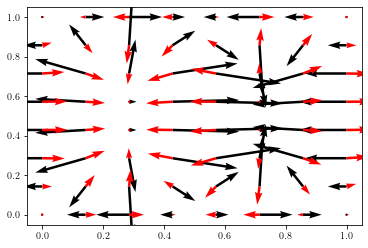

In [34]:
# np.set_printoptions(precision=3,formatter={'float': '{: 0.3f}'.format})
# print('V_vac:',V,sep='\n')
Ex,Ey = update_E(Ex_vac,Ey_vac,eps_rel)

In [35]:
# cond = (X >= 0.3) and (X <= 0.7) and (Y >= 0.25) and (Y <= 0.75)
# (Ex/Ex_vac)#[X >= 0.3 and X <= 0.7 and Y >= 0.25 and Y <= 0.75]

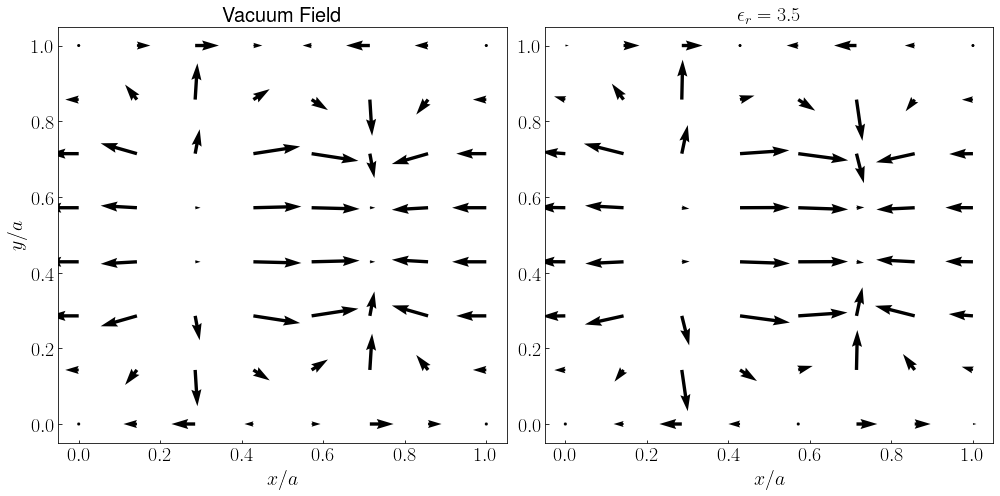

In [36]:
nrows=1;ncols=2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,7*nrows))

ax[0].quiver(X,Y,Ex_vac,Ey_vac)
ax[1].quiver(X,Y,Ex,Ey)
ax[0].set_ylabel(r'$y/a$',size=20)
for i in range(2):
    ax[i].set_xlabel(r'$x/a$',size=20)
    ax[i].tick_params(axis='both',which='major',labelsize=20,direction='in')
ax[0].set_title('Vacuum Field',size=20)
ax[1].set_title(r'$\epsilon_r = 3.5$',size=20)

plt.tight_layout()
# plt.savefig('./plots/E_field-er_3.png',bbox_inches='tight')
plt.show()